In [1]:
!pip install torchvision
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [39]:
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
transform_train =transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test =transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [40]:
local_dir_train = "seg_train/seg_train"
local_dir_test = "seg_test/seg_test"

In [ ]:
dataset =datasets.ImageFolder(root=local_dir_train,transform=transform_train)
# dataset_val =datasets.ImageFolder(root=local_dir_train,transform=transform_test)
dataset_test =datasets.ImageFolder(root=local_dir_test,transform=transform_test)

In [48]:
train_loader =DataLoader(dataset ,batch_size=32,shuffle=True)
test_loader =DataLoader(dataset_test,batch_size=32,shuffle=False)

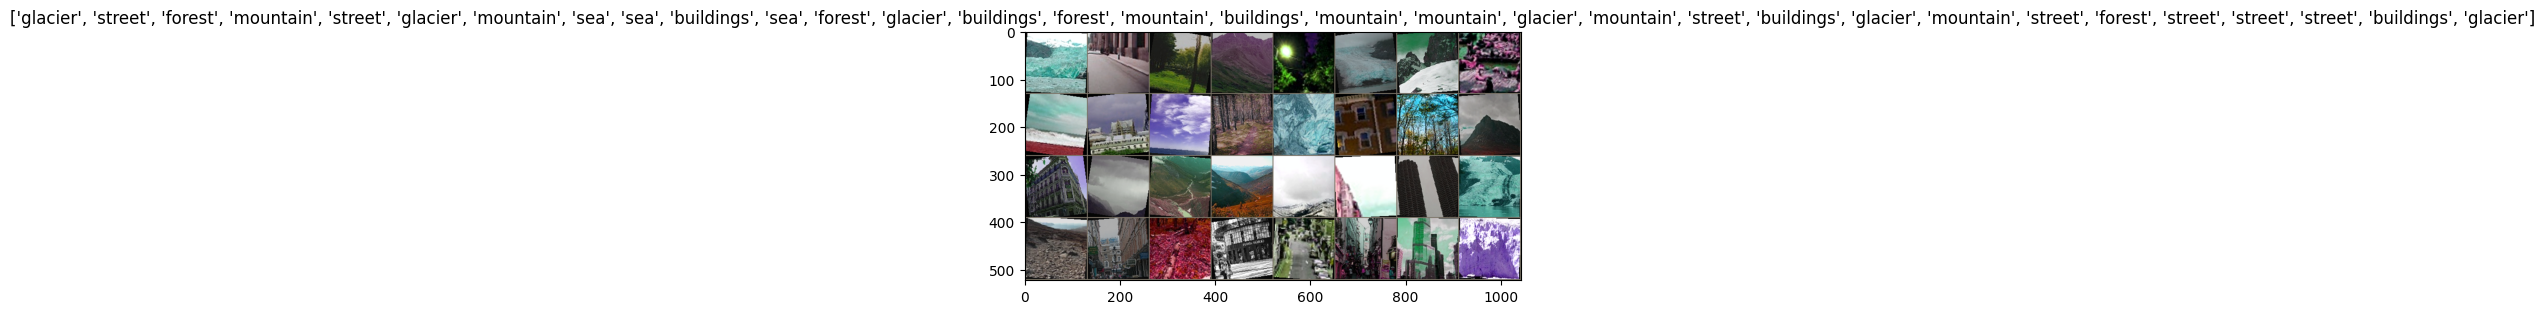

In [49]:
# Function to visualize a batch of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dataset.classes[x] for x in classes])

In [50]:
import torch.nn as nn
import torch.optim as optim

In [54]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,padding=1)#out channels == number of filters we are applying
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1)#out channels == number of filters we are applying
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1)#out channels == number of filters we are applying
        self.pool =nn.MaxPool2d(kernel_size=2,stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128*16*16, out_features=512)
        self.fc2 = nn.Linear(512, out_features=6)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self,x):
        x=self.pool(self.relu(self.conv1(x)))
        x=self.pool(self.relu(self.conv2(x)))
        x=self.pool(self.relu(self.conv3(x)))   
        x=x.view(x.size(0),-1)#flatten the tensor
        x=self.relu(self.fc1(x))#applying relu for the first fully connected layer
        x=self.dropout(x)
        x=self.fc2(x)
        return x

In [55]:
model=CNN()
critirion =nn.CrossEntropyLoss()
optimizer =optim.Adam(model.parameters(),lr=0.001)

In [56]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss =0.0
    for inputs,labels in train_loader:
        optimizer.zero_grad()
        outputs =model(inputs)
        loss =critirion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/5, Loss: 1.2428770004209462
Epoch 2/5, Loss: 0.9839904442735034
Epoch 3/5, Loss: 0.8842179005401282
Epoch 4/5, Loss: 0.8127817868643307
Epoch 5/5, Loss: 0.7659603838632753


In [57]:
# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 82.80%


In [58]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device
